In [12]:
from sympy.polys.domains import QQ

from sympy.polys.rings import ring

from sympy.polys.ring_series import rs_mul, rs_trunc, rs_diff, rs_series_inversion

R, z = ring('z', QQ)

In [13]:
NN = 100 #maximal size

maxRed = 5

listOfLists = []

for i in range(0,maxRed+1):
    listOfLists += [[(0,0) for i in range(0,NN)]]

listOfLists[0][0] = (1,0)

for k in range(1,NN):
     
    n = 3*k + 2
    
    nMinusOne = 3*(k-1) + 2
    
    diffieTerm = 0
    for j in range(0, maxRed):
        
        diffieTerm = 2 * nMinusOne * sum(listOfLists[j][k-1]) - (nMinusOne + 1)/3 * sum(listOfLists[j][k-1]) 
        
        diffieTerm += (nMinusOne + 1)/3 * sum(listOfLists[j-1][k-1]) -  (j-1) * sum(listOfLists[j-1][k-1])
        diffieTerm += (j+1) * sum(listOfLists[j+1][k-1])

        listOfLists[j][k] = (diffieTerm,0)
        
    
    for j in range(0, maxRed):
        
        appTerm = 0 
        
        for h in range(0,(j-1)+1):
                for l in range(0,(k-1)+1):
                    appTerm += listOfLists[h][l][0] *  sum(listOfLists[(j-1)-h][(k-1)-l])

        for h in range(0,j+1):
                for l in range(0,(k-1)+1):
                    appTerm += listOfLists[h][l][1] *  sum(listOfLists[j-h][(k-1)-l])

        listOfLists[j][k] = tuple(map(operator.add, listOfLists[j][k], (0,appTerm)))


In [14]:
G = DiGraph(weighted=True,loops=True)

maxRed = 5

for k in range(0,NN):
     
    n = 3*k + 2
    
    nMinusOne = 3*(k-1) + 2
    
    for j in range(0,maxRed):
        
        termVertex = ('term',j,k)
        
        absWeight = listOfLists[j][k][0]
        appWeight = listOfLists[j][k][1]

        totalNum = sum(listOfLists[j][k])
        
        if totalNum > 0:
            G.add_vertex(termVertex)
        else:
            break
        
        if absWeight != 0 and k > 0:
            const1Weight = 0
            const2Weight = 0
            const3Weight = 0
                       
            absVertex = ('abs',j,k)
            G.add_vertex(absVertex)
            G.add_edge(termVertex, absVertex, absWeight/totalNum)
                       
            #first abs construction: take a term of j redices and cut anywhere except on the left or a lam
            if (listOfLists[j][k-1][0] != 0):
                const1Vertex = ('absConst1',j,k-1)
                G.add_vertex(const1Vertex)
                const1Weight = 2 * nMinusOne * sum(listOfLists[j][k-1]) - (nMinusOne + 1)/3 * sum(listOfLists[j][k-1]) 
                G.add_edge(absVertex, const1Vertex,const1Weight/absWeight)

            #second abs construction: increase redices in a term of j-1 redices by a cut
            if (listOfLists[j-1][k-1][0] != 0):
                const2Vertex = ('absConst2',j-1,k-1)
                G.add_vertex(const2Vertex)
                const2Weight = (nMinusOne + 1)/3 * sum(listOfLists[j-1][k-1]) -  (j-1) * sum(listOfLists[j-1][k-1])
                G.add_edge(absVertex, const2Vertex,const2Weight/absWeight)

            #third construction: decrease redices in a term of (j+1) redices by a cut
            if (listOfLists[j+1][k-1][0] != 0):
                const3Vertex = ('absConst3',j+1,k-1)
                G.add_vertex(const3Vertex)
                const3Weight = (j+1) * sum(listOfLists[j+1][k-1])
                G.add_edge(absVertex,const3Vertex,const3Weight/absWeight)
            
            if (const1Weight+const2Weight+const3Weight != absWeight):
                print("Error: weights don't add up",k,j)
        
        if (appWeight != 0):
            
            appVertex = ('app',j,k)
            G.add_vertex(appVertex)
            G.add_edge(termVertex, appVertex, appWeight/totalNum)

            #first app construction: lambda on the left

            appLamWeight = 0
            for h in range(0,(j-1)+1):
                    for l in range(0,(k-1)+1):
                        appLamWeight += listOfLists[h][l][0] *  sum(listOfLists[(j-1)-h][(k-1)-l])

            if (appLamWeight != 0):
                appLamVertex = ('appLam',j,k)
                G.add_vertex(appLamVertex)
                G.add_edge(appVertex,appLamVertex,appLamWeight/appWeight)

                #passing again to record the individual probabilities for each construction
                for h in range(0,(j-1)+1):
                    for l in range(0,(k-1)+1):
                        currentVertex =  ('appConst1',h,l,(j-1)-h,(k-1)-l)
                        currentWeight = listOfLists[h][l][0] *  sum(listOfLists[(j-1)-h][(k-1)-l])
                        G.add_edge(appLamVertex,currentVertex,currentWeight/appLamWeight)

            appAppWeight = 0

            for h in range(0,j+1):
                for l in range(0,(k-1)+1):
                    appAppWeight += listOfLists[h][l][1] *  sum(listOfLists[j-h][(k-1)-l])
                       
            if (appAppWeight != 0):
                appAppVertex = ('appApp',j,k)
                G.add_vertex(appAppVertex)
                G.add_edge(appVertex, appAppVertex,appAppWeight/appWeight)

                for h in range(0,j+1):
                        for l in range(0,(k-1)+1):
                            currentVertex = ('appConst2',h,l,j-h,(k-1)-l)
                            currentWeight = listOfLists[h][l][1] *  sum(listOfLists[j-h][(k-1)-l])
                            if currentWeight != 0:
                                G.add_edge(appAppVertex,currentVertex,currentWeight/appAppWeight)


In [18]:
def relabeler(x,num):
    return (x[0]+num,) + x[1:]

Constructing a term
Success!


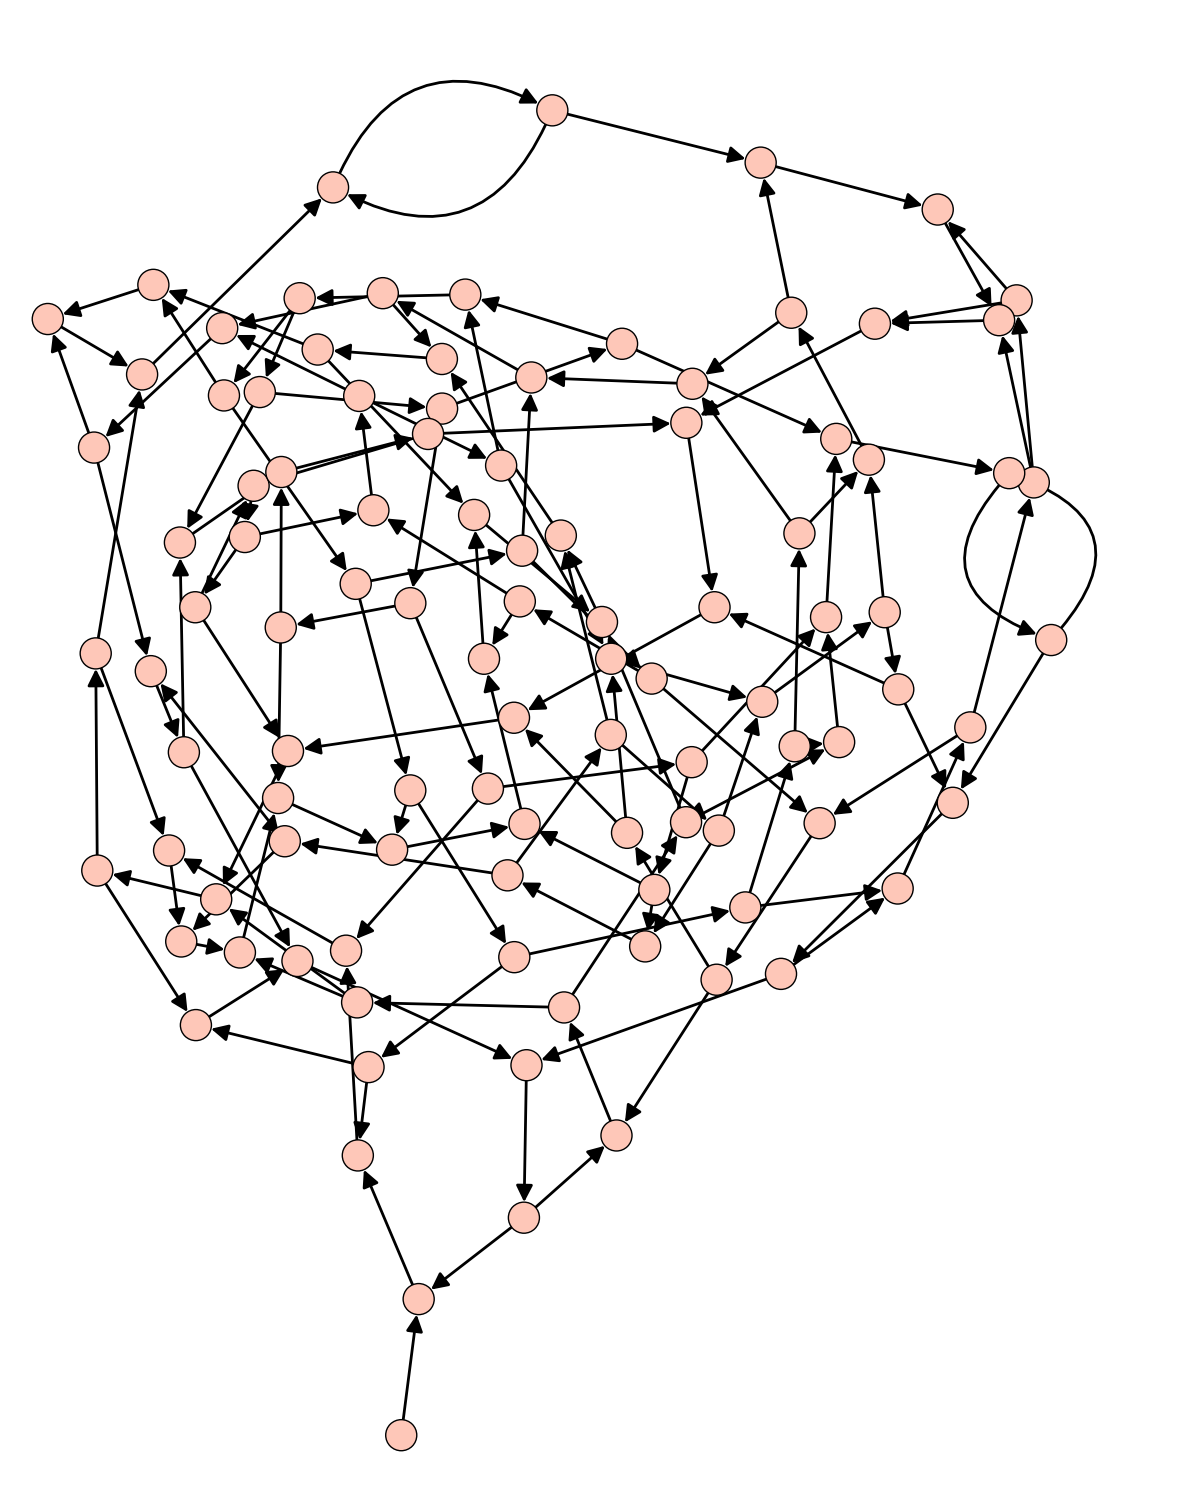

(Looped digraph on 102 vertices, None)

In [59]:
from numpy.random import choice

def constructObject(vertex,G):

    T = DiGraph(loops=True)
    root = None
    
    lastVertex = vertex
    
    notDone = True

    if vertex == ('abs',0,0) or lastVertex == ('term',0,0):
        T = DiGraph(loops=True)
        root = (0, 'root')
        T.add_vertex(root)
        lamVer = (1, 'lam', False)
        T.add_vertex(lamVer)
        T.add_edge(root,lamVer,('r',False))
        T.add_edge(lamVer,lamVer,('loop',True)) #the string records the ordering (outgoing) and 
        #the boolean in the pair records whether this is a var-edge
        return T, root
    
    if not (vertex in G):
        print("error", vertex, "not in G")
        return None, None

        
    while notDone and lastVertex in G:
        
        outNeighs = [tuplet[1] for tuplet in G.edges_incident(lastVertex)]
        probas = [tuplet[2] for tuplet in G.edges_incident(lastVertex)]
        
        if outNeighs != []:
            if (sum(probas) != 1):
                print("Error: Probabilities don't add up",lastVertex,outNeighs, probas)
            lastVertex = outNeighs[int(choice(len(outNeighs), 1, p=probas))]
        else:
            notDone = False 
            
            if lastVertex == ('abs', 0, 0) or lastVertex == ('term',0,0):
                T = DiGraph(loops=True)
                root = (0, 'root')
                T.add_vertex(root)
                lamVer = (1, 'lam', False)
                T.add_vertex(lamVer)
                T.add_edge(root,lamVer,('r',False))
                T.add_edge(lamVer,lamVer,('loop',True))
            
            #first abs construction: take a term of j redices and cut anywhere except on the left or a lam
            elif lastVertex[0] == "absConst1":
                T, oldRoot = constructObject(('abs',lastVertex[1],lastVertex[2]),G)
                
                edgeToCut = T.random_edge()
                oldOrigin = edgeToCut[0]
                oldTarget = edgeToCut[1]

                oldRootsNeigh = T.neighbors_out(oldRoot)[0]

                T.delete_vertex(oldRoot)
                T.delete_edge(edgeToCut)

                newAppVertex = (T.num_verts()+1, 'app')
                newLamVertex = (T.num_verts()+2, 'lam', False)
                root = (T.num_verts()+3, 'root')

                T.add_vertex(newAppVertex)
                T.add_vertex(newLamVertex)
                T.add_vertex(root)

                T.add_edge(root,newLamVertex,('rootEdge',False))

                if (oldOrigin != oldRoot):
                    T.add_edge(newLamVertex,oldRootsNeigh,('r',False))
                else:
                    T.add_edge(newLamVertex,newAppVertex,('r',False))

                if edgeToCut[1][1] == 'app':
                    if (oldOrigin != oldRoot):
                        T.add_edge(oldOrigin,newAppVertex,(edgeToCut[2][0],False)) #whatever orientation we where before
                    if choice([0,1]) == 0:
                        T.add_edge(newAppVertex,oldTarget,('r',edgeToCut[2][1])) #50/50 here normally
                        T.add_edge(newAppVertex,newLamVertex,('l',True))
                    else:
                        T.add_edge(newAppVertex,oldTarget,('l',edgeToCut[2][1])) #50/50 here normally
                        T.add_edge(newAppVertex,newLamVertex,('r',True))
                    

                else:
                    if (oldOrigin != oldRoot):
                        T.add_edge(oldOrigin,newAppVertex,(edgeToCut[2][0],False)) #whatever orientation we where before

                    T.add_edge(newAppVertex,oldTarget,('l',edgeToCut[2][1])) #in case of lams we only have one choice: cut on the right
                    T.add_edge(newAppVertex,newLamVertex,('r',True))
                    
            #second abs construction: increase redices in a term of j-1 redices by a cut
            elif lastVertex[0] == "absConst2":

                T, oldRoot = constructObject(('abs',lastVertex[1],lastVertex[2]),G)
                                
                foundGoodEdge = False
                while not foundGoodEdge:
                    edgeToCut = T.random_edge()
                    if edgeToCut[1][1] == 'lam' and (edgeToCut[0] != edgeToCut[1]) and (edgeToCut[2][1] == False): #gotta check if cutting above a redex-lam
                        if edgeToCut[1][2] == True:
                            edgeToCut = T.random_edge()
                        else:
                            foundGoodEdge = True #found a lam which isn't in a redex
                oldOrigin = edgeToCut[0]
                oldTarget = edgeToCut[1]
                
                replacedTarget = (oldTarget[0],oldTarget[1],True) #lam became redex now!
                T.add_vertex(replacedTarget)
                
                for inEdge in T.incoming_edges(oldTarget):
                    T.add_edge(inEdge[0],replacedTarget,inEdge[2])
                for outEdge in T.outgoing_edges(oldTarget):
                    T.add_edge(replacedTarget,outEdge[1],outEdge[2])
                
                T.delete_vertex(oldTarget)
                                
                oldRootsNeigh = T.neighbors_out(oldRoot)[0]

                T.delete_vertex(oldRoot)
                T.delete_edge(edgeToCut)
                T.delete_edge(oldOrigin,replacedTarget)

                newAppVertex = (T.num_verts()+1, 'app')
                newLamVertex = (T.num_verts()+2, 'lam', False)
                root = (T.num_verts()+3, 'root')

                T.add_vertex(newAppVertex)
                T.add_vertex(newLamVertex)
                T.add_vertex(root)

                T.add_edge(root,newLamVertex,('rootEdge',False))

                if (oldOrigin != oldRoot):
                    T.add_edge(newLamVertex,oldRootsNeigh,('r',False))
                else:
                    T.add_edge(newLamVertex,newAppVertex,('r',False))
                    
                    
                if (oldOrigin != oldRoot):
                    T.add_edge(oldOrigin,newAppVertex,(edgeToCut[2][0],False)) #whatever orientation we where before
                T.add_edge(newAppVertex,replacedTarget,('r',edgeToCut[2][1])) #here only one choice to increase: cut on the left
                T.add_edge(newAppVertex,newLamVertex,('l',True))
                
            #third construction: decrease redices in a term of (j+1) redices by a cut                
            elif lastVertex[0] == "absConst3":
                
                T, oldRoot = constructObject(('abs',lastVertex[1],lastVertex[2]),G)
                                
                foundGoodEdge = False
                while not foundGoodEdge:
                    edgeToCut = T.random_edge()
                    if edgeToCut[1][1] == 'lam' and (edgeToCut[0] != edgeToCut[1]) and (edgeToCut[2][1] == False): #gotta check if cutting above a redex-lam
                        if edgeToCut[1][2] == False:
                            edgeToCut = T.random_edge()
                        else:
                            foundGoodEdge = True #found a lam which is in a redex
                            
                oldOrigin = edgeToCut[0]
                oldTarget = edgeToCut[1]
                
                replacedTarget = (oldTarget[0],oldTarget[1],False) #lam became non-redex now!
                T.add_vertex(replacedTarget)
                
                for inEdge in T.incoming_edges(oldTarget):
                    T.add_edge(inEdge[0],replacedTarget,inEdge[2])
                for outEdge in T.outgoing_edges(oldTarget):
                    T.add_edge(replacedTarget,outEdge[1],outEdge[2])
            
                T.delete_vertex(oldTarget)

                oldRootsNeigh = T.neighbors_out(oldRoot)[0]

                T.delete_vertex(oldRoot)
                T.delete_edge(edgeToCut)
                T.delete_edge(oldOrigin,replacedTarget)
                
                newAppVertex = (T.num_verts()+1, 'app')
                newLamVertex = (T.num_verts()+2, 'lam', False)
                root = (T.num_verts()+3, 'root')

                T.add_vertex(newAppVertex)
                T.add_vertex(newLamVertex)
                T.add_vertex(root)

                T.add_edge(root,newLamVertex,('rootEdge',False))

                if (oldOrigin != oldRoot):
                    T.add_edge(newLamVertex,oldRootsNeigh,('r',False))
                else:
                    T.add_edge(newLamVertex,newAppVertex,('r',False))
                    
                    
                if (oldOrigin != oldRoot):
                    T.add_edge(oldOrigin,newAppVertex,(edgeToCut[2][0],False)) #whatever orientation we where before
                    
                T.add_edge(newAppVertex,replacedTarget,('l',edgeToCut[2][1])) #here only one choice to decrease: cut on the right
                T.add_edge(newAppVertex,newLamVertex,('r',True))

            elif lastVertex[0] == "appConst1":
                
                #applying a lam to something:
                rightSubtree,rightRoot = constructObject(('abs',lastVertex[1],lastVertex[2]),G)
                leftSubtree,leftRoot = constructObject(('term',lastVertex[3],lastVertex[4]),G)
                                
                leftSubtree.relabel(lambda x: relabeler(x,rightSubtree.num_verts()),inplace=True)
                
                shiftedLeftRoot = (leftRoot[0]+rightSubtree.num_verts(),)+leftRoot[1:]
    
                rightRootsNeigh = rightSubtree.neighbors_out(rightRoot)[0]
                rightSubtree.delete_vertex(rightRoot)
                leftRootsNeigh = leftSubtree.neighbors_out(shiftedLeftRoot)[0]
                leftSubtree.delete_vertex(shiftedLeftRoot)
                                
                T = DiGraph(loops=True)
                
                root = (rightSubtree.num_verts()+leftSubtree.num_verts()+1, 'root')
                newAppVertex = (rightSubtree.num_verts()+leftSubtree.num_verts()+2, 'app')
                
                T.add_vertex(root)
                T.add_vertex(newAppVertex)
                T.add_edge(root,newAppVertex,('rootEdge',False))
                
                T.add_edge(newAppVertex, rightRootsNeigh, ('r',False))
                T.add_edge(newAppVertex, leftRootsNeigh, ('l',False))
                
                T=T.union(leftSubtree)
                T=T.union(rightSubtree)
                
            elif lastVertex[0] == "appConst2":
                
                #applying an app to something
                rightSubtree,rightRoot = constructObject(('app',lastVertex[1],lastVertex[2]),G)
                leftSubtree,leftRoot = constructObject(('term',lastVertex[3],lastVertex[4]),G)
                
                leftSubtree.relabel(lambda x: relabeler(x,rightSubtree.num_verts()),inplace=True)
                
                shiftedLeftRoot = (leftRoot[0]+rightSubtree.num_verts(),leftRoot[1])
                    
                rightRootsNeigh = rightSubtree.neighbors_out(rightRoot)[0]
                rightSubtree.delete_vertex(rightRoot)
                leftRootsNeigh = leftSubtree.neighbors_out(shiftedLeftRoot)[0]
                leftSubtree.delete_vertex(shiftedLeftRoot)

                
                T = DiGraph(loops=True)
                
                root = (rightSubtree.num_verts()+leftSubtree.num_verts()+1, 'root')
                newAppVertex = (rightSubtree.num_verts()+leftSubtree.num_verts()+2, 'app')
                
                T.add_vertex(root)
                T.add_vertex(newAppVertex)
                T.add_edge(root,newAppVertex,('rootEdge', False))
                
                T.add_edge(newAppVertex, rightRootsNeigh, ('r',False))
                T.add_edge(newAppVertex, leftRootsNeigh, ('l',False))
                
                T=T.union(leftSubtree)
                T=T.union(rightSubtree)

                
            else:
                return None, None

            
    return T, root
                


jj = 0 #number of redices
kk = 50 #size

a,b = constructObject(('term',jj,kk),G)
print("Constructing a term")
while a.num_edges() != 3*kk+2:
    a,b = constructObject(('term',jj,kk),G)
    print("Failed to generate a proper term!")
print("Success!")
a,a.show(figsize=20,vertex_size=25,vertex_labels=False,edge_style='-')

In [60]:
#Verifying that the generated term has the correct number of redices.
counter = 0
for vertex in a.vertices():
    if vertex[1]=="lam" and vertex[2] == True:
        counter += 1
        
print(jj == counter)

True


/tmp/ipykernel_5891/2940400437.py:3: DeprecationWarning: parameter 'sort' will be set to False by default in the future
See http://trac.sagemath.org/22349 for details.
  for vertex in a.vertices():


In [61]:
newA = DiGraph(loops=True)

for vertex in a.vertices():
    newA.add_vertex((vertex[0],vertex[1]))
    
for edge in a.edges():
    #if edge[0][1] == "lam" or edge[1][1]:
    #    print(edge[0][:2])
    newA.add_edge(edge[0][:2],edge[1][:2],edge[2][0]) #dont forget to erase the label here too, since the true/false dont exist

/tmp/ipykernel_5891/751373845.py:3: DeprecationWarning: parameter 'sort' will be set to False by default in the future
See http://trac.sagemath.org/22349 for details.
  for vertex in a.vertices():
/tmp/ipykernel_5891/751373845.py:6: DeprecationWarning: parameter 'sort' will be set to False by default in the future
See https://trac.sagemath.org/27408 for details.
  for edge in a.edges():


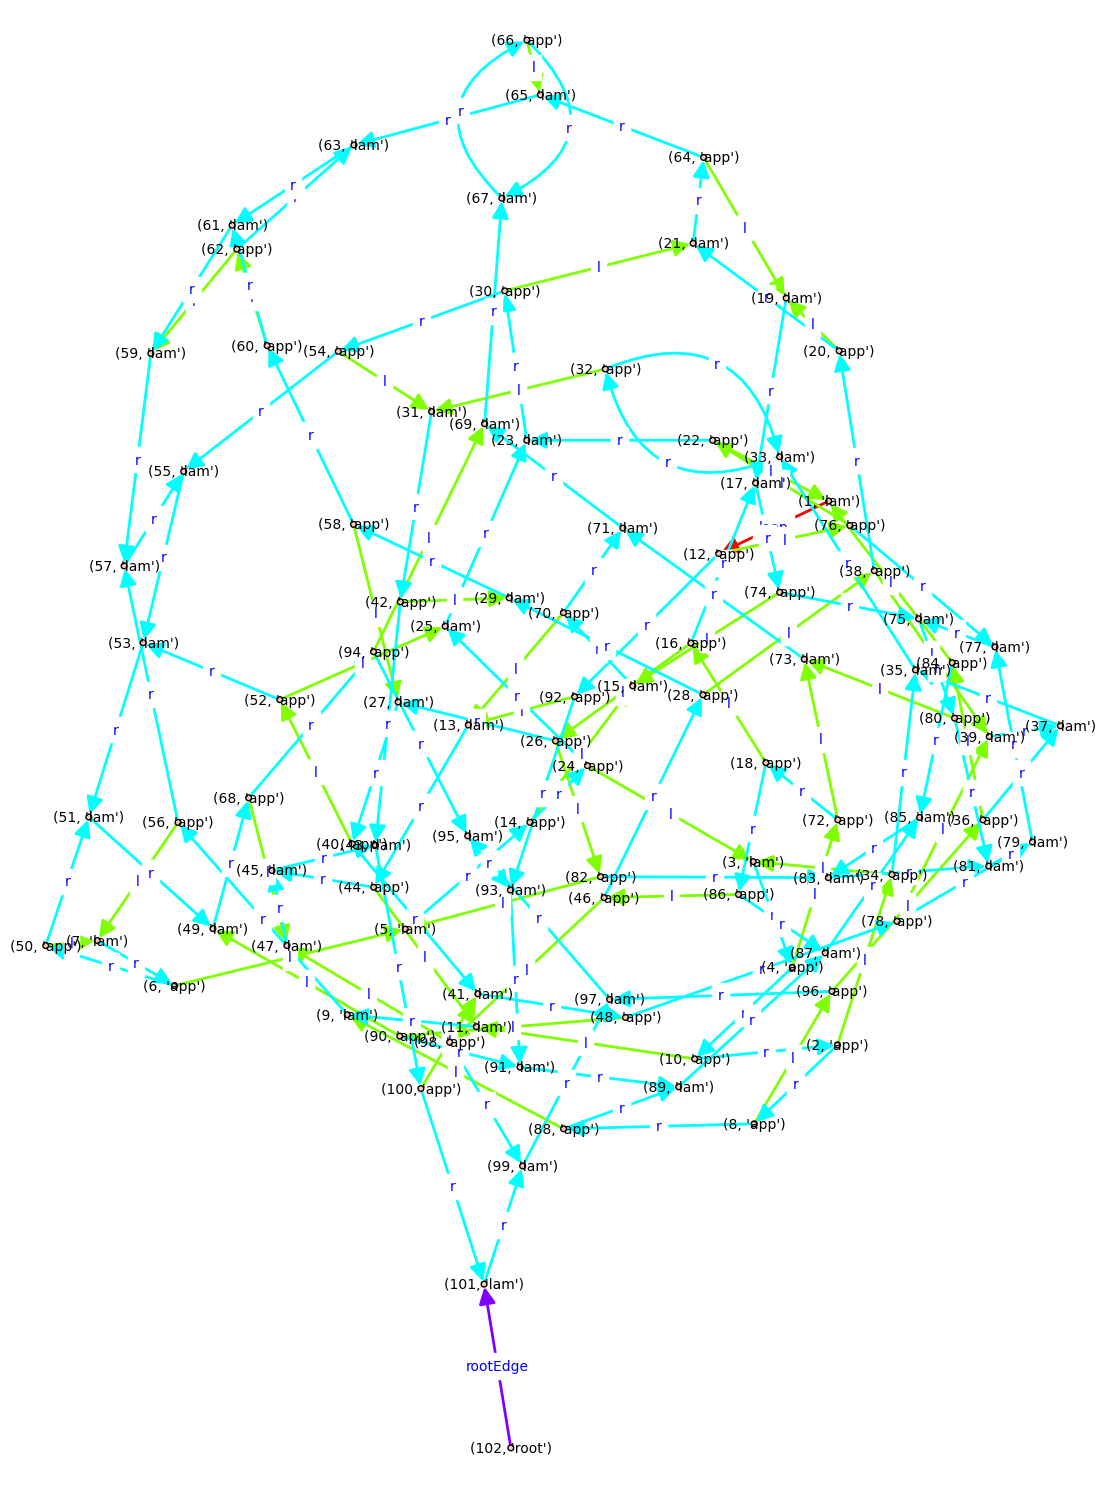

In [62]:
newA.plot(vertex_size = 1, edge_thickness=0, color_by_label=True, edge_labels=True, figsize=[14,15]) 